# **<center>SumajGAN</center>** 

## Load libraries

In [57]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import tensorflow_addons as tfa 
import time
import os
from imageio import imwrite
from datetime import timedelta
import json
from matplotlib import pyplot as plt
from IPython import display

## Global parameters

In [58]:
DATAROOT = "DATASET/pairedmakeup/"
EXT_IMAGE = "jpg"
EXPERIMENT_NAME = "PRUEBA6"
IMG_SAMPLE = "234902233995212020.jpg" ## Folder test

display_infomation = True 
model_retrained = False

EPOCHS = 200

BATCH_SIZE = 1
IMG_SIZE = 512
CHANNEL = 3

LEARNING_RATE = 2e-5
BETA_1_ADAM = 0.3

LAMBDA_TARGET = 100
LAMBDA_MAKEUP = 90
LAMBDA_IDENTITY = 80

START_WITH = 0
FRECUENCY_EPOCH_SAVE = 1

### Create experiment folder

In [59]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [60]:
createFolder("EXPERIMENTS/"+EXPERIMENT_NAME)

In [61]:
createFolder("EXPERIMENTS/"+EXPERIMENT_NAME+"/CHECKPOINT")
createFolder("EXPERIMENTS/"+EXPERIMENT_NAME+"/CHECKPOINT/LOGS")

## Load Sample Paired Makeup Data

In [62]:
def load_paired(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]//3

    input_image = image[:,:w,:]
    reference_image = image[:,w:w*2,:]
    output_image = image[:,w*2:w*3,:]
  
    image_size_ = tf.shape(output_image)

    input_image = tf.cast(input_image, tf.float32)
    reference_image = tf.cast(reference_image, tf.float32)
    output_image = tf.cast(output_image, tf.float32)

    return input_image, reference_image, output_image

## Image normalize

In [63]:
@tf.function()
def normalize(input_image, ref_image, output_image):
    input_image = (input_image / 127.5) - 1
    ref_image = (ref_image / 127.5) - 1
    output_image = (output_image / 127.5) - 1
    return input_image, ref_image, output_image

In [64]:
@tf.function()
def load_image_train(image_file):
    input_image, ref_image, out_image = load_paired(image_file)
    input_image, ref_image, out_image = normalize(input_image, ref_image, out_image)
    return input_image, ref_image, out_image

In [65]:
@tf.function()
def load_image_test(image_file):
    input_image, ref_image, out_image = load_paired(image_file)
    input_image, ref_image, out_image = normalize(input_image, ref_image, out_image)
    return input_image, ref_image, out_image

## Load all dataset to TF

In [66]:
train_dataset = tf.data.Dataset.list_files(DATAROOT + '/train/*.' + EXT_IMAGE)
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
#train_dataset = train_dataset.shuffle(tf.data.experimental.cardinality(train_dataset).numpy())
train_dataset = train_dataset.shuffle(400)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [67]:
test_dataset = tf.data.Dataset.list_files(DATAROOT + '/test/*.' + EXT_IMAGE)
test_dataset = test_dataset.map(load_image_test,num_parallel_calls=tf.data.experimental.AUTOTUNE)
#test_dataset = test_dataset.shuffle(tf.data.experimental.cardinality(test_dataset).numpy())
test_dataset = test_dataset.shuffle(400)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [68]:
sample_dataset = load_image_test(DATAROOT + '/test/' + IMG_SAMPLE)

### Sample

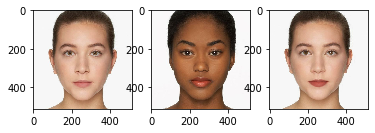

In [69]:
img_input = sample_dataset[0]
img_ref = sample_dataset[1]
img_out = sample_dataset[2]

if(display_infomation):
    f,ax = plt.subplots(1,3)
    ax[0].imshow( img_input * 0.5 + 0.5)
    ax[1].imshow(img_ref  * 0.5 + 0.5)
    ax[2].imshow( img_out * 0.5 + 0.5)
    plt.show()

###**<center>Create Model</center>**

## Generator Model

In [70]:
def Generator(in_bottleneck = True, in_sk = True):
    input_source = tf.keras.layers.Input(shape=[IMG_SIZE,IMG_SIZE,CHANNEL], name="input_source")
    input_reference = tf.keras.layers.Input(shape=[IMG_SIZE,IMG_SIZE,CHANNEL], name="input_reference")

  ######################################################### ENCODER ######################################################################
  ##### Source layers
  ## 1
    c1_s = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(input_source)
    c1_s = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c1_s)
    p1_s = tf.keras.layers.MaxPooling2D((2, 2))(c1_s)
  ## 2
    c2_s = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(p1_s)
    c2_s = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c2_s)
    p2_s = tf.keras.layers.MaxPooling2D((2, 2))(c2_s)
  ## 3
    c3_s = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(p2_s)
    c3_s = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c3_s)
    p3_s = tf.keras.layers.MaxPooling2D((2, 2))(c3_s)
  ## 4
    c4_s = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(p3_s)
    c4_s = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c4_s)
    p4_s = tf.keras.layers.MaxPooling2D((2, 2))(c4_s)

  ##### Reference layers
  ## 1
    c1_r = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(input_reference)
    c1_r = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c1_r)
    p1_r = tf.keras.layers.MaxPooling2D((2, 2))(c1_r)
  ## 2
    c2_r = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(p1_r)
    c2_r = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c2_r)
    p2_r = tf.keras.layers.MaxPooling2D((2, 2))(c2_r)
  ## 3
    c3_r = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(p2_r)
    c3_r = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c3_r)
    p3_r = tf.keras.layers.MaxPooling2D((2, 2))(c3_r)
  ## 4
    c4_r = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(p3_r)
    c4_r = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
    padding='same')(c4_r)
    p4_r = tf.keras.layers.MaxPooling2D((2, 2))(c4_r)

   ######################################################### BOTTLENECK ######################################################################
    if(in_bottleneck):
        c5_b = tf.keras.layers.concatenate([p4_s, p4_r])
        c5_b = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu,
        kernel_initializer='he_normal',padding='same')(c5_b)
    else:
        c5_b = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, 
        kernel_initializer='he_normal',padding='same')(p4_s)
    c5_b = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, 
    kernel_initializer='he_normal',padding='same')(c5_b)

   ######################################################### DECODER ######################################################################
  ## 1
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5_b)
    if in_sk:
        u6 = tf.keras.layers.concatenate([u6, c4_s, c4_r])
    else:
        u6 = tf.keras.layers.concatenate([u6, c4_s])       
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(c6)
  ## 2
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    if in_sk:
        u7 = tf.keras.layers.concatenate([u7, c3_s, c3_r])
    else:
        u7 = tf.keras.layers.concatenate([u7, c3_s])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(c7)
  ## 3
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    if in_sk:
        u8 = tf.keras.layers.concatenate([u8, c2_s, c2_r])
    else:
        u8 = tf.keras.layers.concatenate([u8, c2_s])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(c8)
  ## 4
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    if in_sk:
        u9 = tf.keras.layers.concatenate([u9, c1_s, c1_r])
    else:
        u9 = tf.keras.layers.concatenate([u9, c1_s])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(c9)


    last = tf.keras.layers.Conv2D(CHANNEL, (3, 3),
                                         padding='same',
                                         kernel_initializer='he_normal',
                                         activation='tanh')
    x = last(c9)

    return tf.keras.Model(inputs=[input_source, input_reference], outputs=x)

### Instance Generator Model

In [71]:
if(model_retrained):
  #try:
    generator = tf.keras.models.load_model('EXPERIMENTS/'+EXPERIMENT_NAME+'/CHECKPOINT/generator.h5')
    print("retrained")
  #except:
  #print("Model not found")
  #generator = Generator(in_sk = False)    
else:  
    generator = Generator(in_sk = False)
    print("new Model")
if(display_infomation):
    createFolder("EXPERIMENTS/"+EXPERIMENT_NAME+"/ARCHITECTURE/")
    tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='EXPERIMENTS/'+EXPERIMENT_NAME+
    '/ARCHITECTURE/model_generator_sumaj_gan.png')

new Model
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


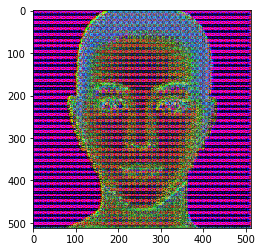

In [72]:
if(display_infomation):
    gen_output = generator([img_input[tf.newaxis,...], img_ref[tf.newaxis,...]], training=False)
    plt.imshow(gen_output[0] * 0.5 + 0.5)

## Discriminator Model

In [73]:
def Discriminator():
  
    inp = tf.keras.layers.Input(shape=[IMG_SIZE,IMG_SIZE,CHANNEL], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_SIZE,IMG_SIZE,CHANNEL], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])
    conv_1 = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same',
    kernel_initializer='he_normal')(x)
    instance_norm1 = tfa.layers.InstanceNormalization()(conv_1)
    leaky_relu1 = tf.keras.layers.LeakyReLU()(instance_norm1)

    conv_2 = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same',
    kernel_initializer='he_normal')(leaky_relu1)
    instance_norm2 = tfa.layers.InstanceNormalization()(conv_2)
    leaky_relu2 = tf.keras.layers.LeakyReLU()(instance_norm2)

    conv_3 = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', 
    kernel_initializer='he_normal')(leaky_relu2)
    instance_norm3 = tfa.layers.InstanceNormalization()(conv_3)
    leaky_relu3 = tf.keras.layers.LeakyReLU()(instance_norm3)

    conv_4 = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', 
    kernel_initializer='he_normal')(leaky_relu3)
    instance_norm4 = tfa.layers.InstanceNormalization()(conv_4)
    leaky_relu4 = tf.keras.layers.LeakyReLU()(instance_norm4)

    conv_5 = tf.keras.layers.Conv2D(1, (4,4), strides=(1,1), padding='same', 
    kernel_initializer='he_normal')(leaky_relu4)
    output = tf.keras.activations.sigmoid(conv_5)

    return tf.keras.Model(inputs=[inp,tar], outputs=[output])

### Instance Discriminator Model

In [74]:
if(model_retrained):
  #try:
    discriminator = tf.keras.models.load_model('EXPERIMENTS/'+EXPERIMENT_NAME+'/CHECKPOINT/discriminator.h5')
  #except:
    #print("Model not found")
    #discriminator = Discriminator()
else:  
    discriminator = Discriminator()

if(display_infomation):
    createFolder("EXPERIMENTS/"+EXPERIMENT_NAME+"/ARCHITECTURE/")
    tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64, to_file='EXPERIMENTS/'+
    EXPERIMENT_NAME+'/ARCHITECTURE/model_discriminator_sumaj_gan.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


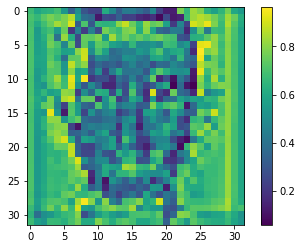

In [75]:
if(display_infomation):
    disc_out = discriminator([img_input[tf.newaxis,...], gen_output], training=False)
    plt.imshow(disc_out[0,..., -1])
    plt.colorbar()

<center></center>

### <center>**Loss Function** </center>

###  Loss Fuction of generator

In [76]:
def generator_loss(disc_generated_output,input_image,reference_image, gen_output,target):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    identity_loss =  tf.reduce_mean(tf.abs(input_image - gen_output)) ### L1
    reference_loss =  tf.reduce_mean(tf.abs(reference_image - gen_output)) ### L1
    target_loss = tf.reduce_mean(tf.abs(target - gen_output)) ### L1
    total_generator_loss = gan_loss + (LAMBDA_TARGET * target_loss) +
    (LAMBDA_MAKEUP * reference_loss) + (LAMBDA_IDENTITY * identity_loss)
    return total_generator_loss 

### Loss Fuction of discriminator

In [77]:
def discriminator_loss(discriminator_real_output, discriminator_fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = cross_entropy(tf.zeros_like(discriminator_fake_output), discriminator_fake_output)
    total_discriminator_loss = real_loss + fake_loss
    return total_discriminator_loss

### <center> **Optimizers** </center>

In [78]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=BETA_1_ADAM)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=BETA_1_ADAM)

### <center> **Metrics** </center>

In [79]:
train_generator_metrics = tf.keras.metrics.Mean(name='train_generator_metrics')
test_generator_metrics = tf.keras.metrics.Mean(name='test_generator_metrics')

train_discriminador_metrics = tf.keras.metrics.Mean(name='train_discriminador_metrics')
test_discriminador_metrics = tf.keras.metrics.Mean(name='test_discriminador_metrics')

## <center>**Training**</center>

### Train Step

In [80]:
@tf.function
def train_step(input_image, reference_image, target, epoch):
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([input_image, reference_image], training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        total_generator_loss = generator_loss(disc_generated_output,input_image, reference_image,gen_output,target)
        total_discriminator_loss = discriminator_loss(disc_real_output, disc_generated_output)

    train_generator_metrics(total_generator_loss)
    train_discriminador_metrics(total_discriminator_loss)

    generator_gradients = gen_tape.gradient(total_generator_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(total_discriminator_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

### Test Step

In [81]:
@tf.function
def test_step(input_image, reference_image, target, epoch):
    gen_output = generator([input_image, reference_image], training=False)

    disc_real_output = discriminator([input_image, target], training=False)
    disc_generated_output = discriminator([input_image, gen_output], training=False)

    total_generator_loss = generator_loss(disc_generated_output,input_image, reference_image,gen_output,target)
    total_discriminator_loss = discriminator_loss(disc_real_output, disc_generated_output)

    test_generator_metrics(total_generator_loss)
    test_discriminador_metrics(total_discriminator_loss)

### Generate image

In [82]:
def generate_images(test_input, reference_input, real_target, epoch, bool_save_img_sample):
    gen_output = generator([test_input[tf.newaxis,...], reference_input[tf.newaxis,...]], training=False)
    if(bool_save_img_sample):
        img_sample_save = gen_output[0] * 0.5 + 0.5
        img_sample_save = img_sample_save.numpy()
        name_save = START_WITH + epoch
        imwrite("EXPERIMENTS/"+EXPERIMENT_NAME + "/SAMPLE/" + str(name_save) + '.png', img_sample_save)

    plt.figure(figsize=(15,15))
    display_list = [test_input, reference_input, real_target, gen_output[0]]
    title = ['Input', 'Reference', 'Real', 'Output generator']

    print("**************************** Epoch: {} ************************************".format(epoch))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### Training process

In [83]:
def fit(train_ds, test_ds, sample_ds, epochs):
    print("Loading...")
    createFolder("EXPERIMENTS/"+EXPERIMENT_NAME+"/SAMPLE/")
    createFolder("EXPERIMENTS/"+EXPERIMENT_NAME+"/LOSS_GRAPH/")

    epoch_list = []
    train_generator_metrics_list = []
    test_generator_metrics_list = []

    train_discriminador_metrics_list = []
    test_discriminador_metrics_list = []

    for epoch in range(0,epochs+1):
        start_time = time.time()

        train_generator_metrics.reset_states()
        test_generator_metrics.reset_states()
        train_discriminador_metrics.reset_states()
        test_discriminador_metrics.reset_states()

        for input_img, reference_img, target_img in train_ds:
            train_step(input_img, reference_img, target_img, epoch)

        for test_input_img, test_reference_img, test_target_img in test_ds:
            test_step(test_input_img ,reference_img ,test_target_img , epoch)

        bool_save_img_sample = False
        if (epoch + 1) % FRECUENCY_EPOCH_SAVE == 0:
            bool_save_img_sample = True

        generator.save('EXPERIMENTS/'+EXPERIMENT_NAME+'/CHECKPOINT/generator.h5')
        discriminator.save('EXPERIMENTS/'+EXPERIMENT_NAME+'/CHECKPOINT/discriminator.h5')

        if(display_infomation):
            display.clear_output(wait=True)
            generate_images(sample_ds[0], sample_ds[1], sample_ds[2], epoch, bool_save_img_sample)

        epoch_list.append(epoch)
        train_generator_metrics_list.append(train_generator_metrics.result())
        test_generator_metrics_list.append(test_generator_metrics.result())

        train_discriminador_metrics_list.append(train_discriminador_metrics.result())
        test_discriminador_metrics_list.append(test_discriminador_metrics.result())


        if(display_infomation):      
            f = open("EXPERIMENTS/"+EXPERIMENT_NAME+"/CHECKPOINT/LOGS/generator_train_loss.txt", 'a')
            f.write('\n'+str(train_generator_metrics.result().numpy()))
            f.close()

            f = open("EXPERIMENTS/"+EXPERIMENT_NAME+"/CHECKPOINT/LOGS/generator_test_loss.txt", 'a')
            f.write('\n'+str(test_generator_metrics.result().numpy()))
            f.close()

            f = open("EXPERIMENTS/"+EXPERIMENT_NAME+"/CHECKPOINT/LOGS/discriminator_train_loss.txt", 'a')
            f.write('\n'+str(train_discriminador_metrics.result().numpy()))
            f.close()

            f = open("EXPERIMENTS/"+EXPERIMENT_NAME+"/CHECKPOINT/LOGS/discriminator_test_loss.txt", 'a')
            f.write('\n'+str(test_discriminador_metrics.result().numpy()))
            f.close()

            plt.figure(figsize=(15,5))
            plt.plot(epoch_list, train_generator_metrics_list, 'r-')
            plt.plot(epoch_list, test_generator_metrics_list, 'r--')
            plt.legend(['Train Generator Loss', 'Test Generator Loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            if(bool_save_img_sample):
                plt.savefig("EXPERIMENTS/"+EXPERIMENT_NAME + "/LOSS_GRAPH/" + 'generator.png')
            plt.show()

            plt.figure(figsize=(15,5))
            plt.plot(epoch_list, train_discriminador_metrics_list, 'g-')
            plt.plot(epoch_list, test_discriminador_metrics_list, 'g--')
            plt.legend(['Train Discriminator Loss','Test Discriminator Loss' ])    
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            if(bool_save_img_sample):
                plt.savefig("EXPERIMENTS/"+EXPERIMENT_NAME + "/LOSS_GRAPH/"+ 'discriminator.png')
            plt.show()

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


**************************** Epoch: 1 ************************************


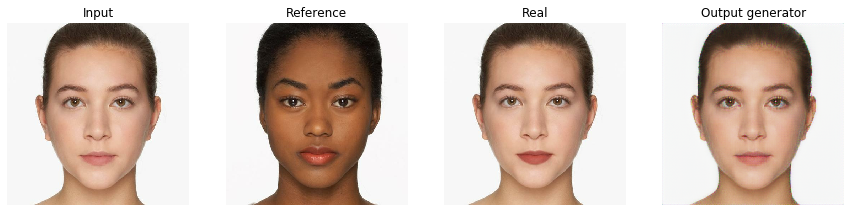

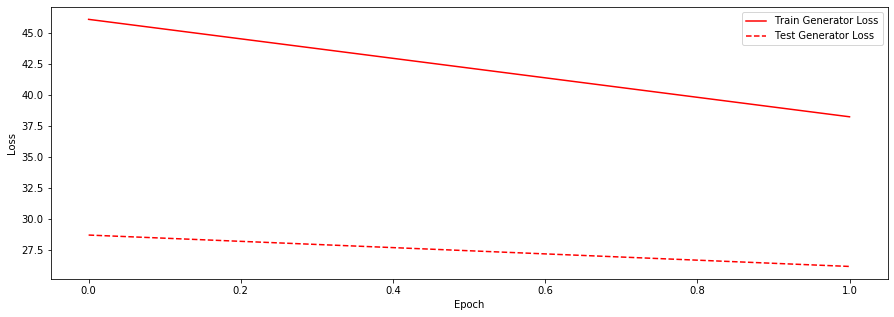

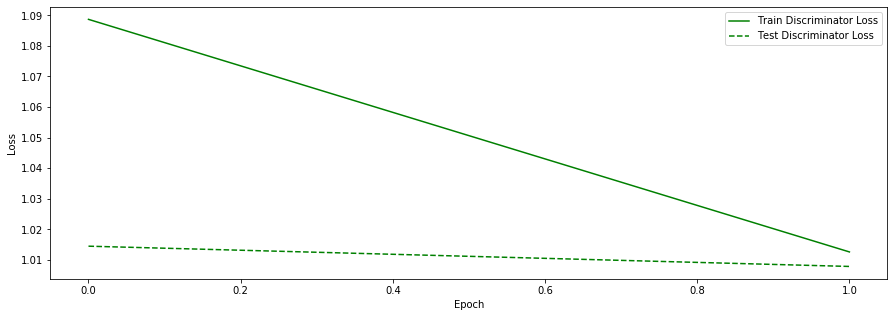

In [ ]:
fit(train_dataset, test_dataset, sample_dataset, EPOCHS)